In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

In [9]:
img = cv2.imread("./cute-images/0000.jpg")

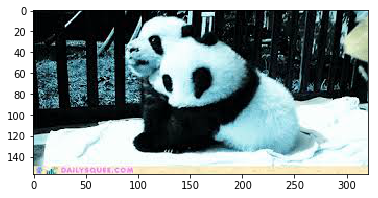

In [10]:
plt.imshow(img)

In [13]:
import os

In [47]:
# Setting cute at index 1.  This will slightly simplify the final rating process
# since we can just average out the values.
CATEGORIES = ["ugly", "cute"]
DIRECTORY = "./Data/Images"

In [49]:
def transform_image(img):
    """
    Adds black padding around an image to make it square,
    then resizes to 96x96, then returns.
    """
    
    # I don't want to stretch the image, so I'll add padding to make it
    # square based on the largest dimension.
    dims = img.shape[:2]
    argmax_dim = np.argmax(dims)
    max_dim = dims[argmax_dim]

    # Shape is height, width, depth.  So, if argmax is 0 then height is max
    # and I should pad the left and right.  Opposite respectively for width.
    padding_amount = abs(np.diff(dims).item()) // 2

    padding_options = {
        0: {'top': 0, 'bottom': 0, 'left': padding_amount, 'right': padding_amount},
        1: {'top': padding_amount, 'bottom': padding_amount, 'left': 0, 'right': 0}
    }

    padding = padding_options[argmax_dim]

    # cv2.copyMakeBorder(src, top, bottom, left, right, method)
    padded = cv2.copyMakeBorder(img, **padding, borderType=cv2.BORDER_ISOLATED)

    resized = cv2.resize(padded, (96, 96))

    return resized

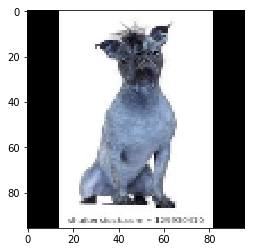

In [50]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        
        # Transformations
        transformed = transform_image(img)
        
        plt.imshow(transformed)
    
        break
    break

In [53]:
def create_dataset():
    dataset = []
    
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)

        # 0 is ugly, 1 is cute
        label = CATEGORIES.index(category)

        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))

            transformed = transform_image(img)

            dataset.append((transformed, label))
            
    return dataset

In [55]:
dataset = create_dataset()

In [58]:
import random

In [59]:
random.shuffle(dataset)

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [46]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [108]:
class AnimalDataset(Dataset):

    def __init__(self, transform=None):
        
        self.data = dataset # A result of create_dataset()
        
        self.transform = transform

    def __len__(self):
        return len(dataset)

    def __getitem__(self, index):
        sample = list(self.data[index])
        
        if self.transform:
            sample[0] = self.transform(sample[0])

        return tuple(sample)

In [109]:
animal_dataset = AnimalDataset(transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

In [110]:
for i in range(3):
    sample = animal_dataset[i]

    print(i, sample[0].size(), sample[1])

    if i == 3:
        break

0 torch.Size([3, 96, 96]) 1
1 torch.Size([3, 96, 96]) 1
2 torch.Size([3, 96, 96]) 0


In [143]:
from torch.utils.data.sampler import SubsetRandomSampler

In [144]:
validation_split = 0.2

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices = indices[split:]
test_indices = indices[:split]

In [145]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [111]:
from torch.utils.data import DataLoader

In [112]:
dataloader = DataLoader(animal_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [150]:
train_loader = DataLoader(animal_dataset, batch_size=4, num_workers=0, sampler=train_sampler)
test_loader = DataLoader(animal_dataset, batch_size=4, num_workers=0, sampler=test_sampler)

In [151]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [152]:
i = np.random.randint(0, len(dataset))
image, label = dataloader.dataset[i]

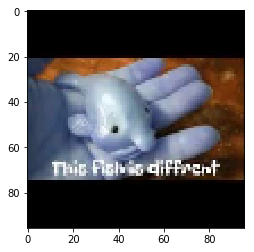

0


In [153]:
imshow(torchvision.utils.make_grid(image))
print(label)

In [209]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 channels in an image, 6 output channels, kernel of 4x4
        self.conv1 = nn.Conv2d(3, 6, 4) # (96 - 5) / 1 + 1 = 92
        self.pool = nn.MaxPool2d(2, 2) # (92 - 2) / 2 + 1 = 46
        self.conv2 = nn.Conv2d(6, 48, 5) # (46 - 5) / 1 + 1 = 42
        self.fc1 = nn.Linear(84672, 8000) # 48 * 42**2 = 84672
        self.fc2 = nn.Linear(8000, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 84672)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [210]:
net(train_loader.dataset[0][0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 3, 3, 3], but got 3-dimensional input of size [3, 96, 96] instead

In [203]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [204]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

ValueError: Expected input batch_size (1) to match target batch_size (4).

In [189]:
96**2 * 3

27648

In [175]:
16 * 5

80

In [176]:
_ * 5

400

In [182]:
48 * 5 * 5

1200